![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    MeteoScreening from database (influxdb)
</b>
</span>

---
**Notebook version**: `4` (31 Oct 2023)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)

</br>

# **ABOUT THIS NOTEBOOK**

In this notebook, the raw data are downloaded from the database, quality-screened, resampled and then uploaded to the database using the [StepwiseMeteoScreeningDb](https://gitlab.ethz.ch/diive/diive/-/blob/main/diive/pkgs/qaqc/meteoscreening.py) class in [diive](https://gitlab.ethz.ch/diive/diive).  

**Here is an overview of what is done in this notebook**:
- (1) **USER SETTINGS**: First, we specify some general settings for the site and variable
- (2) **AUTO-SETTINGS**: With this info, some settings are set automatically
- (3) **DOWNLOAD DATA FROM DATABASE WITH `dbc-influxdb`**: Then original raw data are downloaded from the database. This step uses the Python module  
`dbc-influxdb` to download the data.
- (4) **METEOSCREENING WITH `diive`**: The downloaded data is then quality-screened using the Python library `diive`. The screening is done on the *high-resolution* data,  
i.e., in the original time resolution of the raw data. After the screening, data are resampled to 30MIN time resolution, the same resolution that we typically use for the fluxes.
- (5) **UPLOAD DATA TO THE DATABASE WITH `dbc-influxdb`**: The screened and resampled data are then uploaded to the database.

For more info about Stepwise MeteoScreeningDb, see notebook **Info - StepwiseMeteoScreeningDb**.

</br>

</br>

# **USER SETTINGS** (please adjust)

## Site

In [1]:
SITE = 'ch-fru'
SITE_LAT = 47.115833
SITE_LON = 8.537778

## Variables to screen
- Specify variables as shown in the database
- `FIELDS`: Variables are called FIELDS in the database. InfluxDB stores variable names as '_field'. You can specify multiple fields, given as a list e.g. `['TA_NABEL_T1_35_1', 'TA_T1_20_1]`
- `MEASUREMENTS`: Only **one** measurement allowed. Measurement name that is used to group similar variables together, e.g., `TA` contains all air temperature variables, `SW` are all short-wave radiation measurements and `SWC` all soil water measurements. 

In [2]:
FIELDS = ['SW_IN_T1_1_1', 'SW_IN_T1_2_1']
MEASUREMENT = 'SW'

## Time range to screen
- `START`: Screen data starting with this date (the start date itself **IS** included)
- `STOP`: Screen data before this date (the stop date itself **IS NOT** included)

In [3]:
START = '2023-01-01 00:00:01'
STOP = '2024-01-01 00:00:01'

## Resampling aggregation
- The resampling of the high-res data will be done using this aggregation method; two options: `mean` or `sum`

<div class="alert alert-block alert-info">
    <b>New in notebook v3.2</b>
</div>

<div class="alert alert-block alert-info">
    For <b>precipitation</b> make sure to use `sum` because we need the 30MIN sums.
    
</div>

In [4]:
RESAMPLING_AGG = 'mean'
# RESAMPLING_AGG = 'sum'

</br>

# **AUTO-SETTINGS**

## Data settings

In [5]:
DATA_VERSION = 'raw'
TIMEZONE_OFFSET_TO_UTC_HOURS = 1  # Timezone, e.g. "1" is translated to timezone "UTC+01:00" (CET, winter time)
RESAMPLING_FREQ = '30T'  # During MeteoScreening the screened high-res data will be resampled to this frequency; '30T' = 30-minute time resolution
# DIRCONF = r'P:\Flux\RDS_calculations\_scripts\_configs\configs'  # Location of configuration files, needed e.g. for connection to database
DIRCONF = r'L:\Sync\luhk_work\20 - CODING\22 - POET\configs'

## Imports

In [3]:
from datetime import datetime
import importlib.metadata
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# %matplotlib inline
import pandas as pd
from bokeh.plotting import output_notebook, show
output_notebook()
from dbc_influxdb import dbcInflux  # Needed for communicating with the database
from diive.core.plotting.timeseries import TimeSeries
from diive.core.times.times import DetectFrequency
from diive.pkgs.qaqc.meteoscreening import StepwiseMeteoScreeningDb
from diive.pkgs.outlierdetection.stepwiseoutlierdetection import StepwiseOutlierDetection
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"This page was last modified on: {dt_string}")
version_diive = importlib.metadata.version("dbc_influxdb")
print(f"dbc-influxdb version: v{version_diive}")
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

Loading BokehJS ...

This page was last modified on: 2023-10-31 18:31:03
dbc-influxdb version: v0.10.0
diive version: v0.65.0


## Automatic settings (do not adjust):

In [7]:
BUCKET_RAW=f'{SITE}_raw'  # The 'bucket' where data are stored in the database, e.g., 'ch-lae_raw' contains all raw data for CH-LAE
BUCKET_PROCESSING=f'{SITE}_processing'  # The 'bucket' where data are stored in the database, e.g., 'ch-lae_processing' contains all processed data for CH-LAE
print(f"Bucket containing raw data (source bucket): {BUCKET_RAW}")
print(f"Bucket containing processed data (destination bucket): {BUCKET_PROCESSING}")

Bucket containing raw data (source bucket): ch-fru_raw
Bucket containing processed data (destination bucket): ch-fru_processing


## Connect to database

In [8]:
dbc = dbcInflux(dirconf=DIRCONF)

Reading configuration files was successful.
Connection to database works.


## Check available variables
- Since we are now connected to the database, we can make a quick check if the variable(s) we want to screen are really in the database.  
Below you can show show all available fields in the selected measurement.
- However, if the desired variable(s) are indeed listed here, it does not necessarily mean that they are also available during the  
selected **time period**. This can be the case if the variable(s) for that time period were not uploaded to the database.

In [9]:
# display(dbc.show_fields_in_measurement(bucket=BUCKET_RAW, measurement=MEASUREMENT))

</br>

</br>

# **DOWNLOAD DATA FROM DATABASE WITH `dbc-influxdb`**
- Here the Python library `dbc-influxdb` is used to download data from the database.
- The name of the library means **d**ata**b**ase **c**ommunication using **influxdb**.
- You can find the source code of `dbc-influxdb` [here](https://gitlab.ethz.ch/poet/dbc-influxdb).
- There is no need to adjust the settings here, the variables given earlier (above) are directly used.
- At this point we have already established the connection to the database and stored the connection details in the variable `dbc`.
- Now we can use the method `dbc.download()` to start the data download.

## Download data

In [10]:
%%time
data_simple, data_detailed, assigned_measurements = dbc.download(
    bucket=BUCKET_RAW,
    measurements=[MEASUREMENT],
    fields=FIELDS,
    start=START,
    stop=STOP,
    timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
    data_version=DATA_VERSION
)

    variables ['SW_IN_T1_1_1', 'SW_IN_T1_2_1'] from measurements ['SW']
    between 2023-01-01 00:00:01 and 2024-01-01 00:00:01
    in data version raw
    with timezone offset to UTC of 1
Downloaded data for 1 variables:
    SW_IN_T1_1_1   (433907 records)     first date: 2023-01-01 00:01:00    last date: 2023-10-31 03:59:00
Fields in measurement SW of bucket ch-fru_raw:
#1  ch-fru_raw  SW  SW_IN_T1_1_1
#2  ch-fru_raw  SW  SW_IN_T1_2_1
#3  ch-fru_raw  SW  SW_OUT_T1_1_1
#4  ch-fru_raw  SW  SW_OUT_T1_2_1
Found 4 fields in measurement SW of bucket ch-fru_raw.
CPU times: total: 16.7 s
Wall time: 48.2 s


## Check downloaded data
### `dbc` downloads three variables:
- `data_simple`: This is the simplest data download. It contains only the high-resolution variable(s) from the specified measurement. Each variable is in a separate column. Since different variables, can have different time resolutions, the highest time resolution across the variables is used as the index. This means that lower resolution variables will show gaps in the higher resolution timestamp.
- `data_detailed`: This is the most important variable for the MeteoScreening from the database, because it contains not only the high-resolution time series of the variable(s), but also their tags. The tags are important when uploading data to the database. This is a very special format, because data for each variable are stored in a dictionary. A dictionary is a data structure that stores key-value pairs. The key is the variable name (e.g., `TA_NABEL_T1_35_1`) and the value is a complete dataframe that contains the time series of the respective variable and all tags.
- `assigned_measurements`: An auxiliary variable that is useful to check whether the measurement of the variable(s) is correct. In case we are screening air temperatures, the measurement must be `TA`.

#### `data_simple`
- Simply contains the time series of the measured variable(s) in a nice-to-look-at dataframe.

In [11]:
data_simple

,SW_IN_T1_1_1
TIMESTAMP_END,
2023-01-01 00:01:00,-13.997250
2023-01-01 00:02:00,-12.483430
2023-01-01 00:03:00,-12.284920
2023-01-01 00:04:00,-12.582780
2023-01-01 00:05:00,-12.210560
...,...
2023-10-31 03:55:00,-6.299034
2023-10-31 03:56:00,-6.447832
2023-10-31 03:57:00,-6.423035


#### `data_detailed`
- Dictionary of key-value pairs: the variable name is the key, the respective data (measured time series and tags) are the values

In [12]:
data_detailed

{'SW_IN_T1_1_1':                                                config_filetype data_raw_freq data_version filegroup freq gain hpos raw_units       raw_varname repl  units       varname vpos  SW_IN_T1_1_1
 TIMESTAMP_END                                                                                                                                                                              
 2023-01-01 00:01:00  FRU10-RAW-TBL1-201811051615-TOA5-DAT-1MIN             T          raw  10_meteo    T    1   T1     W m-2  SW_IN_T1_1_1_Avg    1  W m-2  SW_IN_T1_1_1    1    -13.997250
 2023-01-01 00:02:00  FRU10-RAW-TBL1-201811051615-TOA5-DAT-1MIN             T          raw  10_meteo    T    1   T1     W m-2  SW_IN_T1_1_1_Avg    1  W m-2  SW_IN_T1_1_1    1    -12.483430
 2023-01-01 00:03:00  FRU10-RAW-TBL1-201811051615-TOA5-DAT-1MIN             T          raw  10_meteo    T    1   T1     W m-2  SW_IN_T1_1_1_Avg    1  W m-2  SW_IN_T1_1_1    1    -12.284920
 2023-01-01 00:04:00  FRU10-RAW-TBL1-20

<br>
Since the output above is not so nice to look at, we loop through the dictionary and display the first and last records for each variable:

In [13]:
for varname, frame in data_detailed.items():
    print(f"{'-' * 40}\nData for {varname}:")
    display(frame)

----------------------------------------
Data for SW_IN_T1_1_1:


,config_filetype,data_raw_freq,data_version,filegroup,freq,gain,hpos,raw_units,raw_varname,repl,units,varname,vpos,SW_IN_T1_1_1
TIMESTAMP_END,,,,,,,,,,,,,,
2023-01-01 00:01:00,FRU10-RAW-TBL1-201811051615-TOA5-DAT-1MIN,T,raw,10_meteo,T,1,T1,W m-2,SW_IN_T1_1_1_Avg,1,W m-2,SW_IN_T1_1_1,1,-13.997250
2023-01-01 00:02:00,FRU10-RAW-TBL1-201811051615-TOA5-DAT-1MIN,T,raw,10_meteo,T,1,T1,W m-2,SW_IN_T1_1_1_Avg,1,W m-2,SW_IN_T1_1_1,1,-12.483430
2023-01-01 00:03:00,FRU10-RAW-TBL1-201811051615-TOA5-DAT-1MIN,T,raw,10_meteo,T,1,T1,W m-2,SW_IN_T1_1_1_Avg,1,W m-2,SW_IN_T1_1_1,1,-12.284920
2023-01-01 00:04:00,FRU10-RAW-TBL1-201811051615-TOA5-DAT-1MIN,T,raw,10_meteo,T,1,T1,W m-2,SW_IN_T1_1_1_Avg,1,W m-2,SW_IN_T1_1_1,1,-12.582780
2023-01-01 00:05:00,FRU10-RAW-TBL1-201811051615-TOA5-DAT-1MIN,T,raw,10_meteo,T,1,T1,W m-2,SW_IN_T1_1_1_Avg,1,W m-2,SW_IN_T1_1_1,1,-12.210560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31 03:55:00,FRU10-RAW-TBL1-201711201643-TOA5-DAT-1MIN,T,raw,10_meteo,T,1,T1,W m-2,SW_IN_T1_1_1_Avg,1,W m-2,SW_IN_T1_1_1,1,-6.299034
2023-10-31 03:56:00,FRU10-RAW-TBL1-201711201643-TOA5-DAT-1MIN,T,raw,10_meteo,T,1,T1,W m-2,SW_IN_T1_1_1_Avg,1,W m-2,SW_IN_T1_1_1,1,-6.447832
2023-10-31 03:57:00,FRU10-RAW-TBL1-201711201643-TOA5-DAT-1MIN,T,raw,10_meteo,T,1,T1,W m-2,SW_IN_T1_1_1_Avg,1,W m-2,SW_IN_T1_1_1,1,-6.423035


#### `assigned_measurements`
- Contains the *automatically* detected measurement for the selected variables, useful as check to make sure the variable was properly identified.

In [14]:
assigned_measurements

{'SW_IN_T1_1_1': 'SW'}

<br>
It is possible that a variable that we want to screen is not available in the database (oh no). To find out which variable that might be we have this piece of code:

In [15]:
print(f"Data available for: {data_detailed.keys()}\n")
vars_not_available = [v for v in FIELDS if v not in data_detailed.keys()]
print(f"No data available for the following variables: {vars_not_available}")

Data available for: dict_keys(['SW_IN_T1_1_1'])

No data available for the following variables: ['SW_IN_T1_2_1']


<div class="alert alert-block alert-info">
    <b>New in notebook v3.1:</b> Remove variables that are not available during this time period from FIELDS.
</div>

In [16]:
for rem in vars_not_available:
    print(rem)
    FIELDS.remove(rem)
    print(f"Removed variables {rem} from FIELDS because it is not available during this time period.")

SW_IN_T1_2_1
Removed variables SW_IN_T1_2_1 from FIELDS because it is not available during this time period.


## Save downloaded high-res raw data to file (optional)
- If you really want, you can download the full resolution data to a file. This can be useful if you want to do the screening elsewhere.

In [17]:
# data_detailed['TA_NABEL_T1_35_1'].to_csv("mylovelyhorse.csv")

## Plot downloaded high-res data
- Yes, this is indeed a plot of the downloaded full-resolution data.
- Because we have plenty of time and space, each variable gets it's own plot.
- If there is only one variable, then there is only one plot.

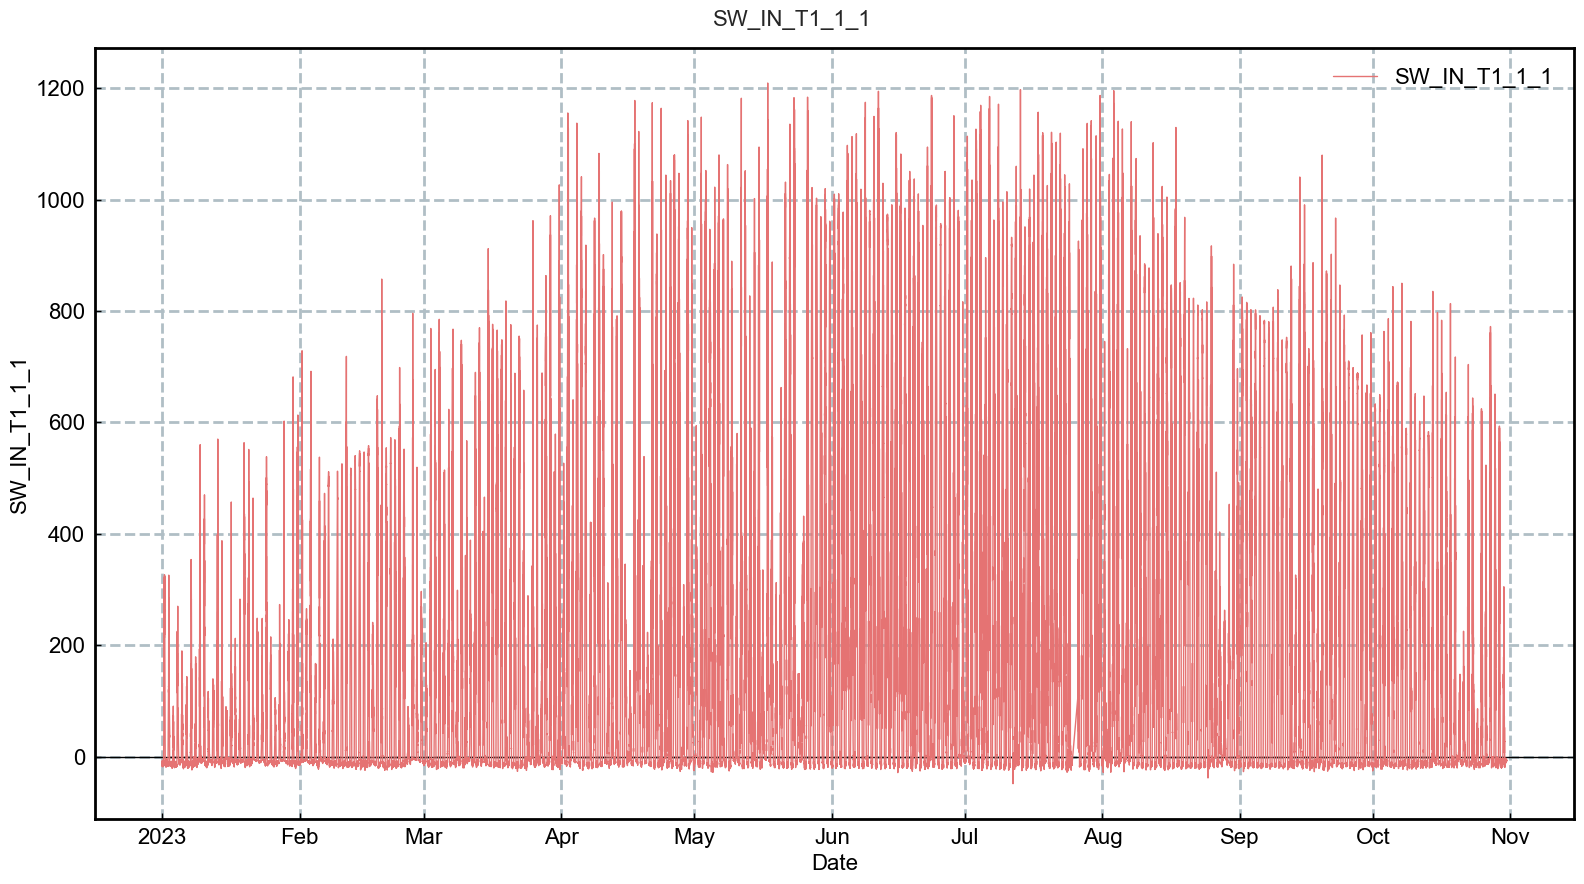

In [18]:
for varname, frame in data_detailed.items():
    # TimeSeries(series=frame[varname]).plot_interactive()
    TimeSeries(series=frame[varname]).plot()

</br>

# **Start MeteoScreening with `diive`**

In [19]:
mscr = StepwiseMeteoScreeningDb(site=SITE,
                                data_detailed=data_detailed,
                                # measurement=MEASUREMENT,
                                fields=FIELDS,
                                site_lat=SITE_LAT,
                                site_lon=SITE_LON,
                                utc_offset=1)

Found 3 unique frequencies across 433719 records.
Found frequencies:
    Found time resolution 60.0 (seconds) with 433709 records (100.00% of total records). 
    Found time resolution 120.0 (seconds) with 7 records (0.00% of total records).   -->  Frequency will be ignored, too few records.
    Found time resolution 180.0 (seconds) with 3 records (0.00% of total records).   -->  Frequency will be ignored, too few records.
The following frequencies will be used: [60.0] (seconds)


<br>
Now let's take a look at the data that will be screened:

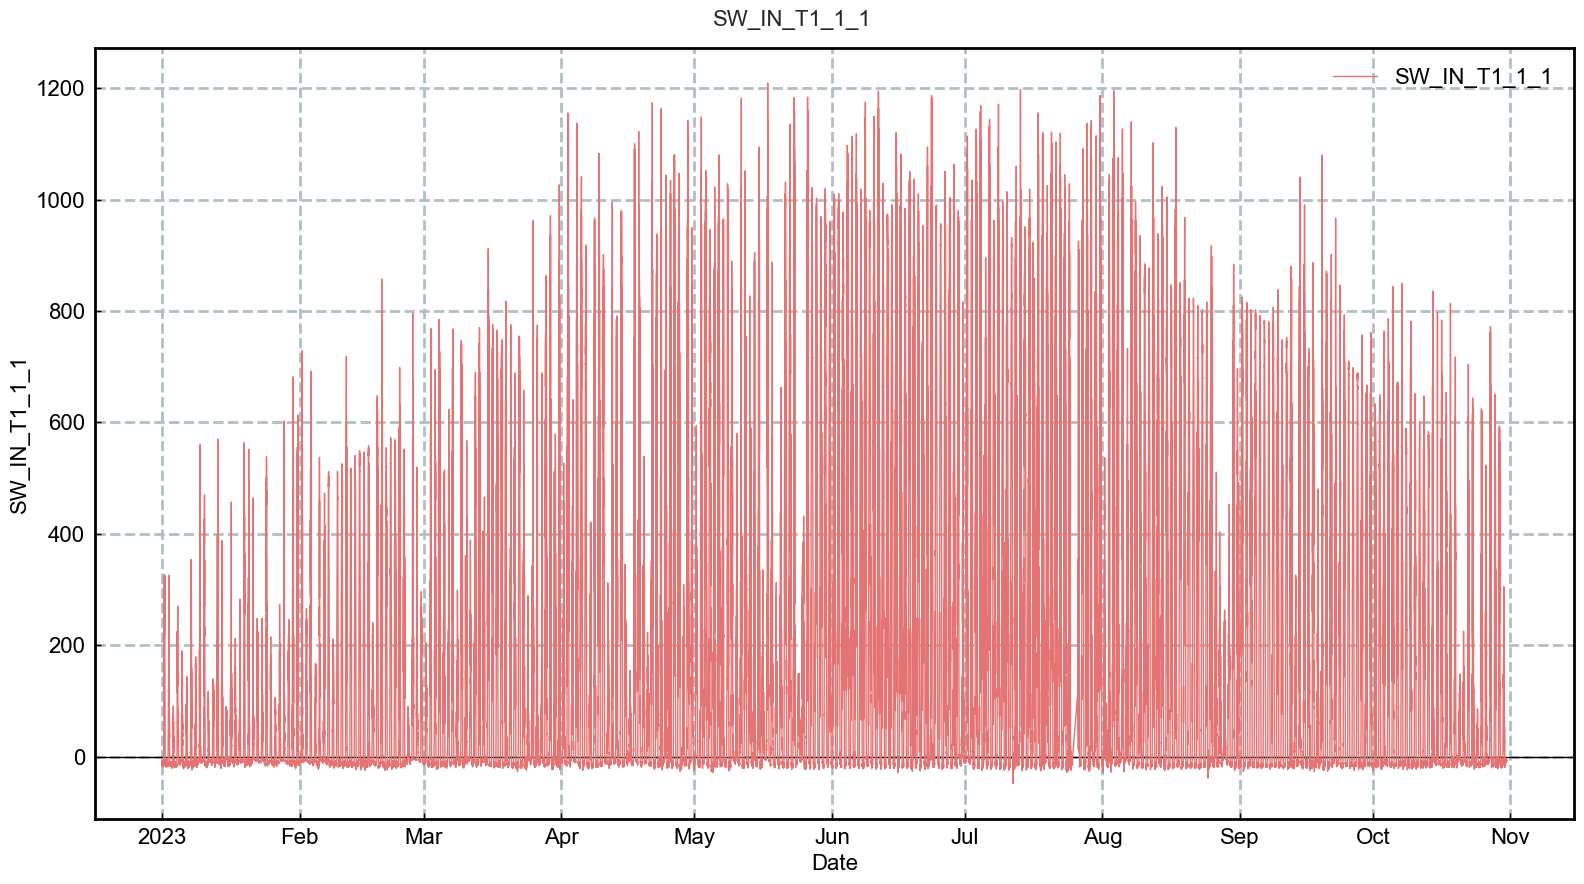

In [20]:
# mscr.showplot_orig(interactive=True)
mscr.showplot_orig()

</br>

</br>

# **OUTLIER DETECTION**: generate quality flags on high-resolution data (if needed)

<div class="alert alert-block alert-info">
    <b>Tip:</b> If the plots look good and you think the data do not require any screening, you can skip this section and jump directly to Corrections or Resampling. 
</div>

</br>

</br>

## Flag, outlier detection: **Missing values test** (always needed)
*Generate flag that indicates missing records in data*

In [ ]:
mscr.flag_missingvals_test()

In [ ]:
mscr.addflag()

</br>

</br>

## Flag, outlier detection: **Manual removal**
*Generate flag for data points that should be removed*

To find erroneous time periods, use this interactive plot to identify the exact timestamps or time ranges:

In [ ]:
# mscr.showplot_cleaned(interactive=True)
mscr.showplot_cleaned(interactive=False)

In [ ]:
# Dates for removal from a previous check, defined in the CONFIG.XLSX for CH-FRU in the old Python MeteoScreening tool
REMOVE_DATES = [
    ['2005-07-15 12:15:00', '2005-09-05 13:45:00'],  # these very first data do not look OK
    ['2005-12-30 12:45:00', '2005-12-30 15:45:00'],  # delete, bad data, CNR1 covered by snow/ice
    ['2006-07-21 15:45:00', '2006-07-21 15:45:00']  # delete, bad data, 
]
REMOVE_DATES

In [ ]:
mscr.flag_manualremoval_test(remove_dates=REMOVE_DATES, showplot=True, verbose=True)

In [ ]:
mscr.addflag()

In [ ]:
# mscr.showplot_cleaned(interactive=True)
mscr.showplot_cleaned(interactive=False)

</br>

</br>

## Flag, outlier detection: **z-score over all data, separate for daytime and nighttime**
*Identify outliers based on the z-score, separately for daytime and nighttime*

<div class="alert alert-block alert-warning">
    <b>Warning for radiation:</b> This test easily removes nighttime values that are below zero. However, below-zero radiation data are corrected in a later step (Corrections). Make sure that no radiation data below zero are removed when using this test.
</div>

<div class="alert alert-block alert-warning">
    <b>Warning for relative humidity:</b> This test easily removes values that are above 100% relative humidity. However, values > 100% are corrected in a later step (Corrections). Make sure that no RH data above 100% are removed when using this test.
</div>

In [ ]:
THRESHOLD = 99
mscr.flag_outliers_zscore_dtnt_test(threshold=THRESHOLD, showplot=True, verbose=True)

In [ ]:
mscr.addflag()

</br>

</br>

## Flag, outlier detection: **z-score over all data**
*Identify outliers based on the z-score of records*  
This is a general purpose test that can already solve many outlier issues.

In [ ]:
THRESHOLD = 5
mscr.flag_outliers_zscore_test(threshold=THRESHOLD, showplot=True, verbose=True)

In [ ]:
mscr.addflag()

</br>

</br>

## Flag, oulier detection: **Local standard deviation**
*Identify outliers based on the local standard deviation, based on the rolling mean and standard deviation*  
<br>
Parameters:
- `N_SD` ... Number of standard deviations for outliers
- `WINSIZE` ... Number of records used for the rolling time window. If `None` the window size is calculated as 1/20 of data length.

In [ ]:
N_SD = 5
WINSIZE = None
mscr.flag_outliers_localsd_test(n_sd=N_SD, winsize=WINSIZE, showplot=True)

In [ ]:
mscr.addflag()

</br>

</br>

## Flag, outlier detection: **Increments z-score**
*Identify outliers based on the z-score of record increments*

In [ ]:
mscr.flag_outliers_increments_zcore_test(threshold=85, showplot=True)

In [ ]:
mscr.addflag()

</br>

</br>

## Flag, outlier detection: **absolute limits, separate for daytime and nighttime data**
*Identify outliers based on absolute limits separately for daytime and nighttime*

In [ ]:
DT_MINMAX = [-99, 2000]
NT_MINMAX = [-99, 99]
mscr.flag_outliers_abslim_dtnt_test(daytime_minmax=DT_MINMAX, nighttime_minmax=NT_MINMAX, showplot=True)

In [ ]:
mscr.addflag()

</br>

</br>

## Flag, outlier detection: **Seasonal trend decomposition with z-score on residuals**
*Seasonsal trend decomposition with z-score on residuals*  
The time series are gap-filled for this method, therefore output from the random forest gap-filling (quick gap-filling) will show up.

In [ ]:
mscr.flag_outliers_stl_rz_test(zfactor=4.5, decompose_downsampling_freq='12H', repeat=False, showplot=True)

In [ ]:
mscr.addflag()

</br>

</br>

## Flag, outlier detection: **Absolute limits**
*Generate flag that indicates if values in data are outside the specified range*

In [ ]:
MIN = -26
MAX = 2000
mscr.flag_outliers_abslim_test(minval=MIN, maxval=MAX, showplot=True)

In [ ]:
mscr.addflag()

In [ ]:
mscr.showplot_cleaned()

</br>

</br>

## Flag, outlier detection: **Thymeboost**
*Identify outliers based on [thymeboost](https://github.com/tblume1992/ThymeBoost)*  
Seems to work OK on air temperature data if time series is not too noisy.  
The time series need gap-filling, therefore some results from the random forest will show up.

In [ ]:
mscr.flag_outliers_thymeboost_test(showplot=True)

In [ ]:
mscr.addflag()

</br>

</br>

## Flag, outlier detection: **Local outlier factor**
*Identify outliers based on the local outlier factor*  
You can find [more info about the general approach here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html).

<div class="alert alert-block alert-danger">
    <b>Do not use this test on high-resolution data (1S, 10S, 1MIN):</b> Computation takes a veeeeery loooong time and is slooooow. But otherwise it works nicely with half-hourly data.
</div>

In [ ]:
# mscr.flag_outliers_lof_test(n_neighbors=None, contamination='auto', showplot=True, verbose=True)

In [ ]:
# mscr.addflag()

</br>

</br>

## Flag, outlier detection: **Local outlier factor, daytime/nighttime**
*Identify outliers based on the local outlier factor, done separately for daytime and nighttime data*  
You can find [more info about the general approach here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html).

<div class="alert alert-block alert-danger">
    <b>Do not use this test on high-resolution data (1S, 10S, 1MIN):</b> Computation takes a veeeeery loooong time and is slooooow. But otherwise it works nicely with half-hourly data.
</div>

In [ ]:
# mscr.flag_outliers_lof_dtnt_test(n_neighbors=None, contamination='auto', showplot=True, verbose=True)

In [ ]:
# mscr.addflag()

</br>

</br>

# **QCF**: calculate overall quality-control flag for high-resolution data  
- The next step (Corrections) needs quality-controlled data.

In [21]:
mscr.calc_qcf()

TypeError: exceptions must derive from BaseException

## Reports

In [ ]:
mscr.report_qcf_evolution()

In [ ]:
mscr.report_qcf_series()

In [ ]:
mscr.report_qcf_flags()

## Plots

In [ ]:
mscr.showplot_qcf_heatmaps(figsize=(18,8))

In [ ]:
mscr.showplot_qcf_timeseries(figsize=(18,8))

</br>

# **CORRECTIONS**: done on high-resolution data (if needed)

Currently only needed for SW, PPFD, RH.

</br>

## Correction: **Remove radiation zero offset**
*Remove nighttime offset from all radiation data and set nighttime to zero*

<div class="alert alert-block alert-info">
    Can be used for <b>SW_IN, SW_OUT, PPFD_IN, PPFD_OUT.</b>
</div>



[remove_radiation_zero_offset]  ========================================
[remove_radiation_zero_offset]  remove_radiation_zero_offset
[remove_radiation_zero_offset]  ========================================
[remove_radiation_zero_offset]  Done.
[remove_radiation_zero_offset]  ________________________________________


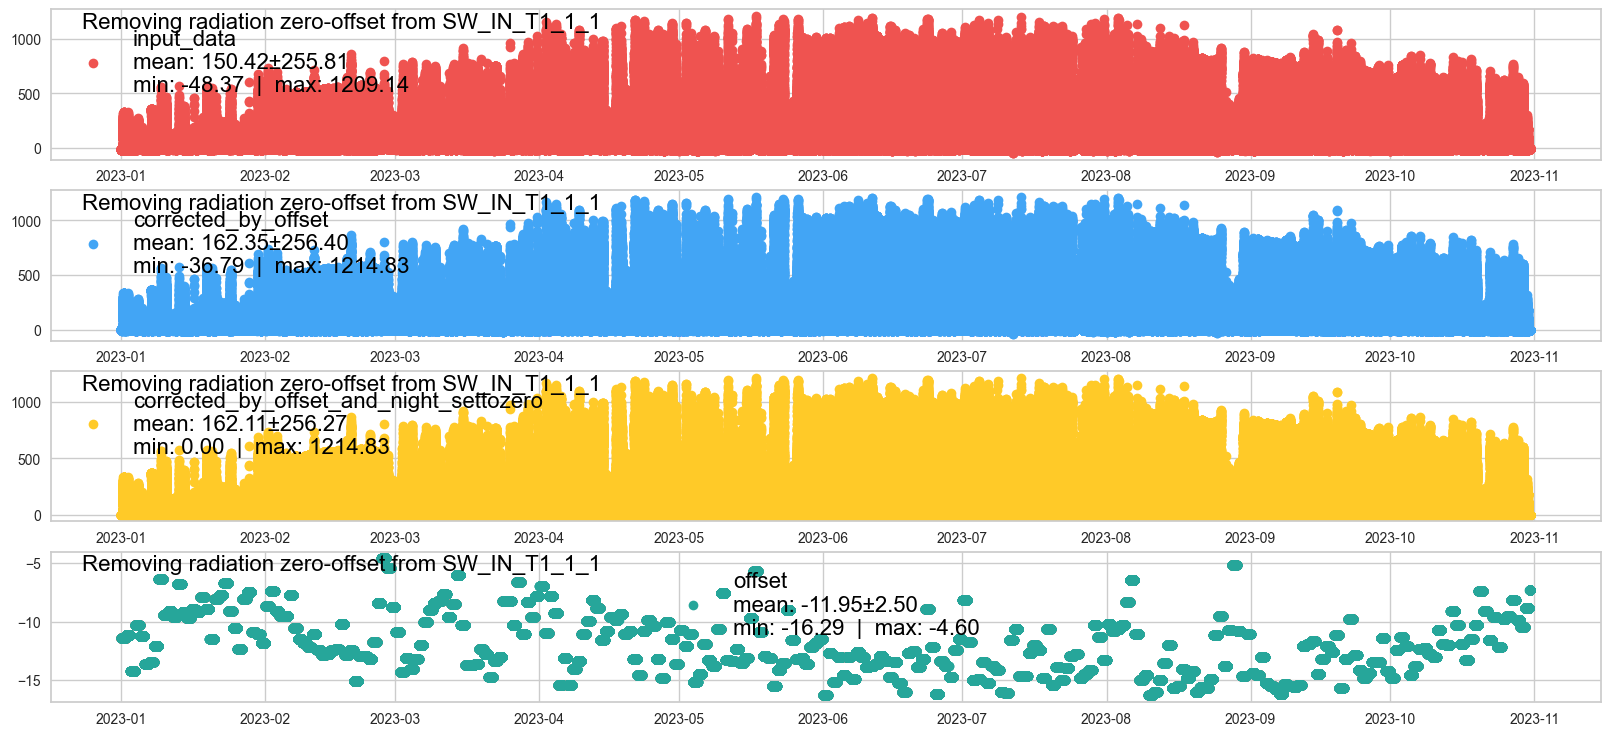

In [22]:
mscr.correction_remove_radiation_zero_offset()

</br>

</br>

## Correction: **Remove relative humidity offset**
*Remove relative humidity offset, works for relative humidity data where maximum values should not exceed 100%*  

<div class="alert alert-block alert-info">
    Can be used for <b>RH.</b>
</div>

In [ ]:
mscr.correction_remove_relativehumidity_offset()

</br>

</br>

## Correction: **Set to max threshold**
*Set values above threshold to threshold*

In [ ]:
mscr.correction_setto_max_threshold(threshold=500)

</br>

</br>

## Correction: **Set to min threshold**
*Set values below threshold to threshold*

In [ ]:
mscr.correction_setto_min_threshold(threshold=200)

</br>

</br>

## Correction: **Set to value**
*Set records in time range(s) to value*
- This can be useful e.g. to set precipitation to zero during a time period where the sensor was tested during a field visit

<div class="alert alert-block alert-info">
    <b>New in notebook v3.2</b>
</div>

In [ ]:
mscr.showplot_cleaned(interactive=True)

In [ ]:
DATES = [
    ['2022-05-01', '2022-12-06'],
    ['2022-01-05', '2022-01-30']
]

In [ ]:
mscr.correction_setto_value(dates=DATES, value=0, verbose=1)

In [ ]:
mscr.showplot_cleaned(interactive=True)

</br>

</br>

# **ANALYSES** <a class="anchor" id="resampling"></a>

## Check for potential timestamp shifts
*Compare radiation time series to potential radiation*

<div class="alert alert-block alert-info">
    <b>New in notebook v3.1</b>
</div>

<div class="alert alert-block alert-info">
    Can be used for <b>SW_IN, SW_OUT, PPFD_IN, PPFD_OUT.</b>
</div>

This analysis generates a plot that shows the radiation time series in comparison to potential radiation.
- The first (top) panel shows daily correlations
- The second panel shows potential radiation and measured radiation on low correlation days all in one plot
- The third panel (with 3 plots) shows potential radiation and measured radiation on the three days when their correlation was the **lowest**
- The fourth (bottom) panel (with 3 plots) shows potential radiation and measured radiation on the three days when their correlation was the **highest**

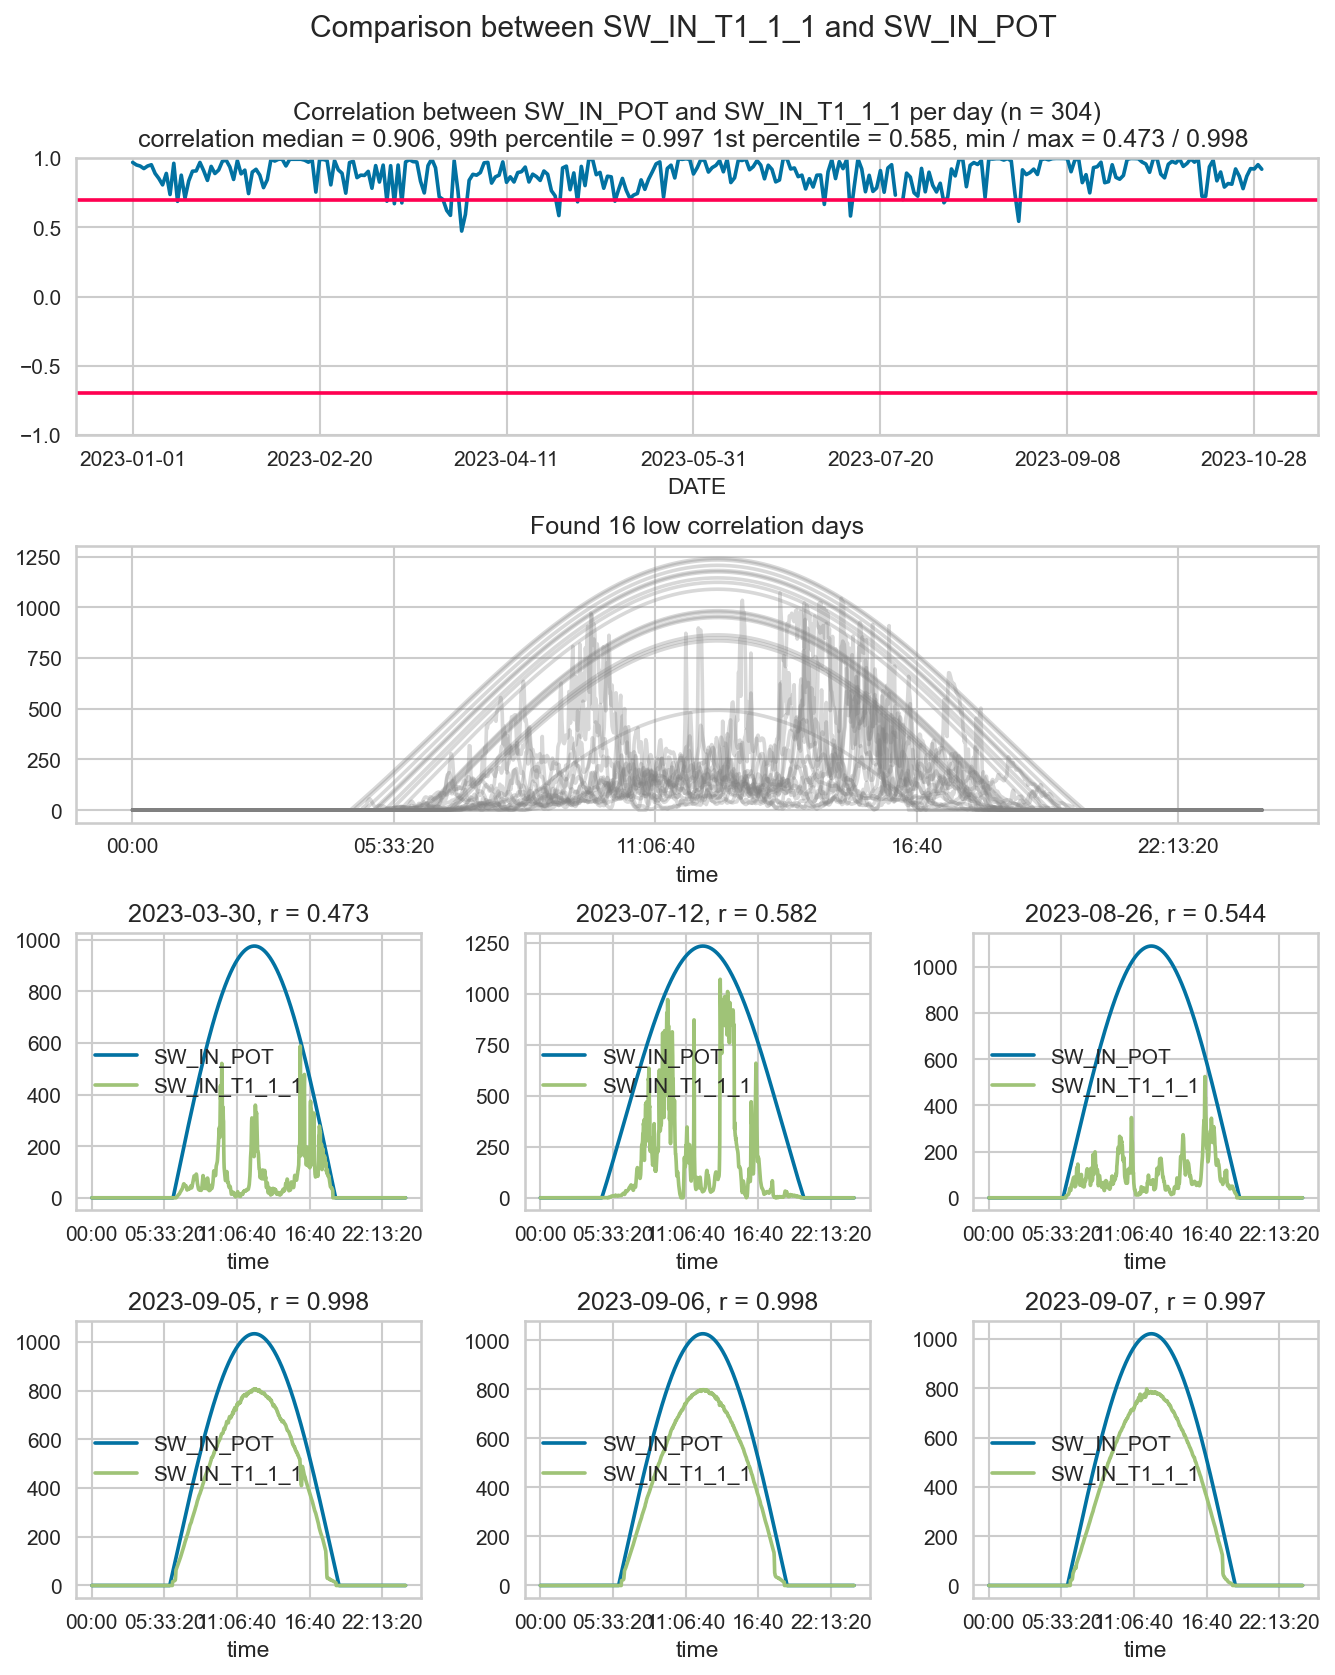

In [23]:
_ = mscr.analysis_potential_radiation_correlation(utc_offset=1, mincorr=0.7, showplot=True)

</br>

</br>

# **RESAMPLING** <a class="anchor" id="resampling"></a>

## Resample

In [24]:
RESAMPLING_AGG

'mean'

In [25]:
mscr.resample(to_freqstr=RESAMPLING_FREQ, agg=RESAMPLING_AGG, mincounts_perc=.25)



[resample_series_to_30MIN]  ========================================
[resample_series_to_30MIN]  resample_series_to_30MIN
[resample_series_to_30MIN]  ========================================
Resampling data from T to 30T frequency ...
[resample_series_to_30MIN]  Done.
[resample_series_to_30MIN]  ________________________________________


## Plot original and resampled data

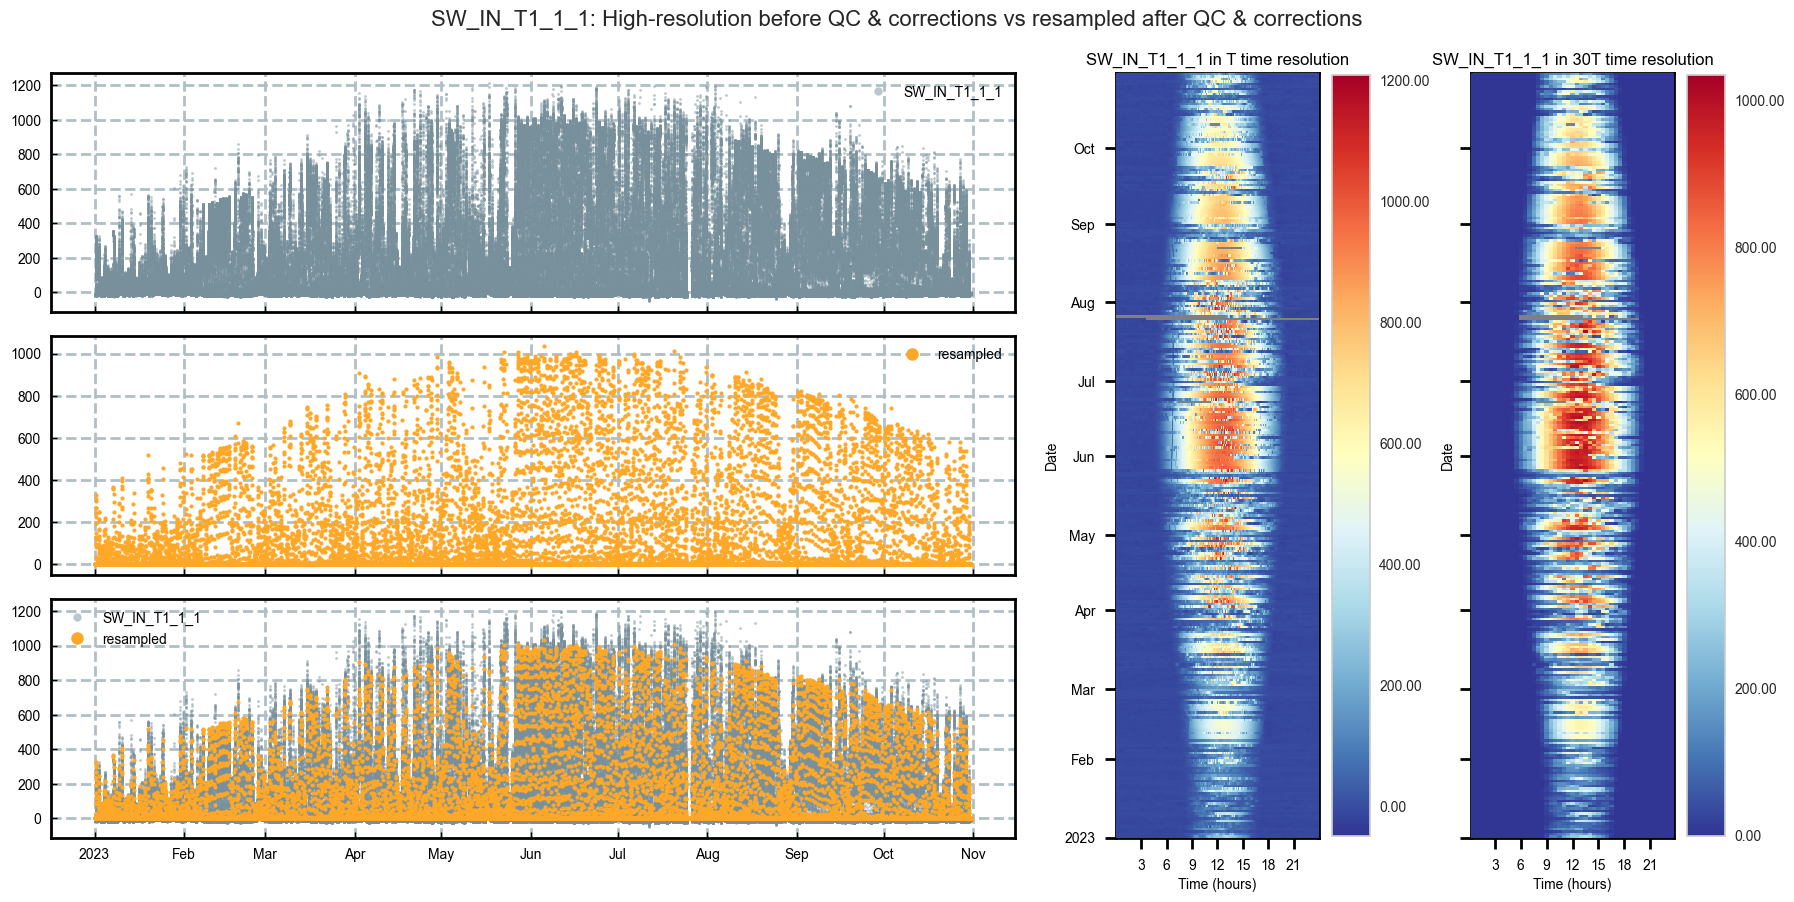

In [26]:
mscr.showplot_resampled()

## Check time resolution of resampled data

In [27]:
for v in mscr.resampled_detailed.keys():   
    print(f"{'-' * 20}\n{v}")
    _checkfreq = DetectFrequency(index=mscr.resampled_detailed[v].index, verbose=True).get()
    if _checkfreq == RESAMPLING_FREQ:
        print(f"TEST PASSED - The resampled variable {v} has a time resolution of {_checkfreq}.")
    else:
        print(f"{'#' * 20}(!)TEST FAILED - The resampled variable {v} does not have the expected time resolution of {_checkfreq}.{'#' * 20}")

--------------------
SW_IN_T1_1_1
Detecting time resolution from timestamp TIMESTAMP_END ... OK
   Detected 30T time resolution with MAXIMUM confidence.
   All approaches yielded the same result:
       from full data = 30T / full data (OK)
       from timedelta = 30T / >90% occurrence (OK)
       from progressive = 30T / data 1000+1000 (OK)

TEST PASSED - The resampled variable SW_IN_T1_1_1 has a time resolution of 30T.


</br>

</br>

---

# **UPLOAD DATA TO THE DATABASE WITH `dbc-influxdb`**

In [28]:
print(f"Data will be uploaded to bucket {BUCKET_PROCESSING}")

Data will be uploaded to bucket ch-fru_processing


In [29]:
for v in mscr.resampled_detailed.keys(): 
    m = assigned_measurements[v]    
    dbc.upload_singlevar(to_bucket=BUCKET_PROCESSING,
                         to_measurement=m,
                         var_df=mscr.resampled_detailed[v],
                         timezone_of_timestamp='UTC+01:00')
    # dbc.upload_singlevar(to_bucket='test', to_measurement=m, var_df=vars_qc_resampled[v], timezone_of_timestamp='UTC+01:00')

Connecting to database ...
--> UPLOAD TO DATABASE BUCKET ch-fru_processing:  ['SW_IN_T1_1_1']
Upload finished.


</br>

</br>

---

# **DATACHECK: DOWNLOAD FROM DATABASE**

In [30]:
dbc = dbcInflux(dirconf=DIRCONF)
# dbc.show_fields_in_measurement(bucket=BUCKET_PROCESSING, measurement='SW')

Reading configuration files was successful.
Connection to database works.


In [31]:
MEASUREMENT = ['SW']
data_simple, data_detailed, assigned_measurements = dbc.download(bucket=BUCKET_PROCESSING,
                                                                 measurements=MEASUREMENT,
                                                                 fields=FIELDS,
                                                                 start=START,
                                                                 stop=STOP,
                                                                 timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
                                                                 data_version='meteoscreening')

    variables ['SW_IN_T1_1_1'] from measurements ['SW']
    between 2023-01-01 00:00:01 and 2024-01-01 00:00:01
    in data version meteoscreening
    with timezone offset to UTC of 1
Downloaded data for 1 variables:
    SW_IN_T1_1_1   (14494 records)     first date: 2023-01-01 00:30:00    last date: 2023-10-31 04:00:00
Fields in measurement SW of bucket ch-fru_processing:
#1  ch-fru_processing  SW  NIGHT
#2  ch-fru_processing  SW  SW_IN_ERA
#3  ch-fru_processing  SW  SW_IN_F
#4  ch-fru_processing  SW  SW_IN_F_MDS
#5  ch-fru_processing  SW  SW_IN_F_MDS_QC
#6  ch-fru_processing  SW  SW_IN_F_QC
#7  ch-fru_processing  SW  SW_IN_POT
#8  ch-fru_processing  SW  SW_IN_T1_1_1
#9  ch-fru_processing  SW  SW_OUT
Found 9 fields in measurement SW of bucket ch-fru_processing.


In [32]:
data_simple

,SW_IN_T1_1_1
TIMESTAMP_END,
2023-01-01 00:30:00,0.0
2023-01-01 01:00:00,0.0
2023-01-01 01:30:00,0.0
2023-01-01 02:00:00,0.0
2023-01-01 02:30:00,0.0
...,...
2023-10-31 02:00:00,0.0
2023-10-31 02:30:00,0.0
2023-10-31 03:00:00,0.0


## Check time resolution of downloaded data

In [33]:
for v in data_detailed.keys():   
    print(f"{'-' * 20}\n{v}")
    _checkfreq = DetectFrequency(index=data_detailed[v].index, verbose=True).get()
    if _checkfreq == RESAMPLING_FREQ:
        print(f"TEST PASSED - The downloaded variable {v} has a time resolution of {_checkfreq}.")
    else:
        print(f"{'#' * 20}(!)TEST FAILED - The downloaded variable {v} does not have the expected time resolution of {_checkfreq}.{'#' * 20}")

--------------------
SW_IN_T1_1_1
Detecting time resolution from timestamp TIMESTAMP_END ... OK (detected 30T time resolution 30T with MEDIUM confidence)
OK
   Detected 30T time resolution with MEDIUM confidence.
   Records at start and end of file have consistent timestamp:
       from full data = None / -failed- (not used)
       from timedelta = 30T / >90% occurrence (not used)
       from progressive = 30T / data 992+992 (OK)

TEST PASSED - The downloaded variable SW_IN_T1_1_1 has a time resolution of 30T.


</br>

---

# **End of notebook.**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [34]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2023-10-31 13:32:54
